In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_data(path):
    return pd.read_csv(path)

data = load_data('./input/train.csv')

In [3]:
submit = load_data('./input/test.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


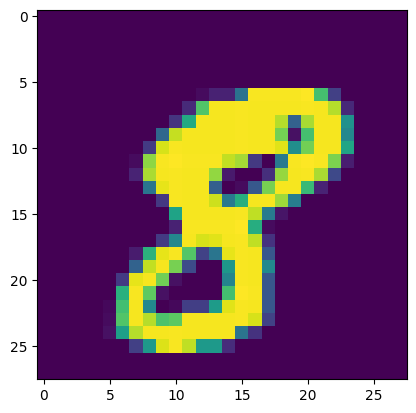

In [6]:
from matplotlib.pyplot import imshow

def display_img_from_dfrow(row):
    sqrt_n_row = int(np.sqrt(len(row)))
    sq_row = row.values.reshape(sqrt_n_row, sqrt_n_row)
    imshow(sq_row)

display_img_from_dfrow(data.iloc[10, 1:])

In [7]:
X, y = data.iloc[:, 1:], data.iloc[:, 0]
X.shape, y.shape

((42000, 784), (42000,))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [166]:
def augment(X_tensor):
    # Move to GPU if not already on it
    device = X_tensor.device

    def blacken_grey_pixels(img, x):
        # Find grey pixels (those not pure black or white)
        img_array = img.clone()  # Avoid modifying the original image
        grey_mask = (img_array > 50) & (img_array < 255)  # Assuming pixel values are 0-255
    
        # Find indices of grey pixels
        grey_indices = grey_mask.nonzero(as_tuple=True)
        num_grey_pixels = grey_indices[0].size(0)
    
        # Determine how many grey pixels to blacken
        num_pixels_to_blacken = int((x / 100.0) * num_grey_pixels)
    
        # Randomly select indices to blacken
        if num_pixels_to_blacken > 0:
            random_indices = random.sample(range(num_grey_pixels), num_pixels_to_blacken)
            selected_indices = (grey_indices[0][random_indices], grey_indices[1][random_indices])
            img_array[selected_indices] = 0  # Set selected grey pixels to black
    
        return img_array
    
    def add_gaussian_noise(img, mean=10, std=5):
        # Ensure noise is on the same device as the input image
        noise = torch.randn(img.size(), device=img.device) * std + mean
        noisy_img = img + noise
        # Clipping the values to stay within valid range [0, 255] for images
        return torch.clamp(noisy_img, 0, 255)
        
    def random_augmentation(img):
        # Random Rotation
        img = transforms.RandomRotation(degrees=45)(img)

        # Random Resized Crop
        scale = random.uniform(0.9, 1.1)
        img = transforms.functional.resized_crop(img, top=0, left=0, height=int(img.shape[1]*scale), width=int(img.shape[2]*scale), size=(28, 28))

        # Random Translation (affine transform provides this functionality)
        translate_x = random.uniform(-0.1, 0.1) * img.size(1)  # Translate by 10% of width
        translate_y = random.uniform(-0.1, 0.1) * img.size(2)  # Translate by 10% of height
        img = transforms.functional.affine(img, angle=0, translate=(translate_x, translate_y), scale=1, shear=0)

        img = blacken_grey_pixels(img, 1)
        img = add_gaussian_noise(img)
            
        return img

    transformed_images = [random_augmentation(img.to(device)) for img in X_tensor]

    return torch.stack(transformed_images).to(device)

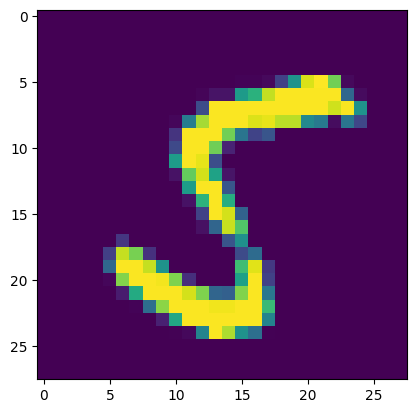

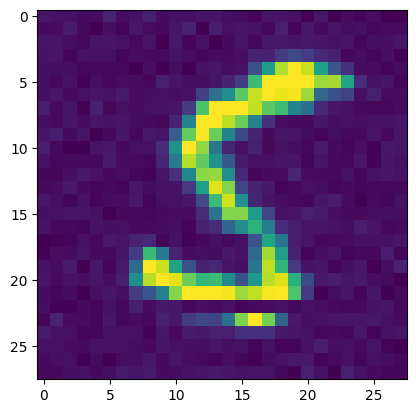

In [167]:
single_X_tensor = X_train_tensor[[1], :, :, :]
plt.imshow(single_X_tensor.cpu().reshape(28, 28))
plt.show()

single_X_tensor_tr = augment(single_X_tensor)
plt.imshow(single_X_tensor_tr.cpu().reshape(28, 28))
plt.show()

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

import random

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.25)

        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.25)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Adjust the dimensions based on the input size
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [168]:
# Set device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

H, W = 28, 28
# Assuming X_train, y_train, X_test, y_test are pandas DataFrames/Series
X_train_tensor = torch.tensor(X_train.values.reshape(-1, 1, H, W), dtype=torch.float32).to(device)
X_train_tensor_aug = augment(X_train_tensor)
X_train_tensor = torch.cat((X_train_tensor, X_train_tensor_aug), dim=0)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_train_tensor = torch.cat((y_train_tensor, y_train_tensor), dim=0)

X_test_tensor = torch.tensor(X_test.values.reshape(-1, 1, H, W), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [169]:
# Assuming train_loader and test_loader are available
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss
    print(f'Train Epoch: {epoch} Loss {total_loss/len(train_loader)}')
    scheduler.step()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(1, 50):  # Train for 10 epochs
    train(model, device, train_loader, optimizer, scheduler, epoch)

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Epoch: 1 Loss 1.705321192741394
Train Epoch: 2 Loss 1.544143557548523
Train Epoch: 3 Loss 1.5209195613861084
Train Epoch: 4 Loss 1.5097572803497314
Train Epoch: 5 Loss 1.5011893510818481
Train Epoch: 6 Loss 1.498327374458313
Train Epoch: 7 Loss 1.4936904907226562
Train Epoch: 8 Loss 1.4907536506652832
Train Epoch: 9 Loss 1.488374948501587
Train Epoch: 10 Loss 1.4875737428665161
Train Epoch: 11 Loss 1.4871115684509277
Train Epoch: 12 Loss 1.4869744777679443
Train Epoch: 13 Loss 1.48748779296875
Train Epoch: 14 Loss 1.4875438213348389
Train Epoch: 15 Loss 1.488896131515503
Train Epoch: 16 Loss 1.4900939464569092
Train Epoch: 17 Loss 1.4906647205352783
Train Epoch: 18 Loss 1.4909552335739136
Train Epoch: 19 Loss 1.491005301475525
Train Epoch: 20 Loss 1.4894553422927856
Train Epoch: 21 Loss 1.488752841949463
Train Epoch: 22 Loss 1.4872885942459106
Train Epoch: 23 Loss 1.4852029085159302
Train Epoch: 24 Loss 1.4833288192749023
Train Epoch: 25 Loss 1.4817978143692017
Train Epoch: 26 Lo

In [177]:
for epoch in range(1, 10):  # Train for 10 epochs
    train(model, device, train_loader, optimizer, scheduler, epoch)

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Epoch: 1 Loss 1.4760371446609497
Train Epoch: 2 Loss 1.4753004312515259
Train Epoch: 3 Loss 1.4751250743865967
Train Epoch: 4 Loss 1.4732778072357178
Train Epoch: 5 Loss 1.4728590250015259
Train Epoch: 6 Loss 1.4716435670852661
Train Epoch: 7 Loss 1.4705638885498047
Train Epoch: 8 Loss 1.4700372219085693
Train Epoch: 9 Loss 1.469565510749817
Test Accuracy: 99.49%
Train Accuracy: 99.59%


In [179]:
# import joblib
# joblib.dump(model, 'digit_recognizer.pkl')

['digit_recognizer.pkl']

In [178]:
def get_predictions(model, loader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for idx, (prediction, label, output) in enumerate(zip(predicted, labels, outputs)):
                image_id = batch_index * loader.batch_size + idx
                # Convert outputs to a list of Python floats
                output_list = output.cpu().numpy().tolist()

                # Append the prediction with the full output vector
                predictions.append((image_id, int(label.item()), int(prediction.item()), *output_list))

    # Create DataFrame with column names including individual class scores
    column_names = ['ImageID', 'True', 'Pred'] + [f'Class_{i}' for i in range(outputs.size(1))]
    predictions_df = pd.DataFrame(predictions, columns=column_names).set_index('ImageID')
    return predictions_df
    
y_train_df = get_predictions(model, train_loader)
y_test_df = get_predictions(model, test_loader)
y_train_df

,True,Pred,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
ImageID,,,,,,,,,,,,
0,0,0,1.000000e+00,3.934011e-22,7.550713e-20,1.011905e-28,1.073957e-23,8.287578e-22,5.264667e-16,1.436284e-25,2.189358e-21,5.619161e-20
1,7,7,1.005028e-09,1.746996e-10,1.653638e-07,1.484405e-11,5.820787e-13,5.029838e-13,4.165039e-18,9.999999e-01,3.866681e-14,4.868004e-10
2,9,9,1.227596e-25,1.560368e-34,2.848481e-33,6.016395e-35,1.426337e-23,1.115177e-36,2.458951e-37,2.324680e-22,3.015901e-27,1.000000e+00
3,9,9,2.589166e-15,5.435106e-22,1.575949e-21,2.508682e-23,4.431704e-16,1.034666e-19,1.610183e-25,3.388925e-14,2.692457e-18,1.000000e+00
4,9,9,1.987932e-16,4.577442e-24,9.617803e-20,1.750773e-25,5.262011e-18,1.925234e-24,7.050294e-27,3.978456e-15,4.111807e-18,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
67195,1,1,1.726882e-10,9.999740e-01,4.704218e-10,6.270304e-09,4.884277e-09,9.650519e-09,1.134439e-13,2.601530e-05,2.799706e-12,2.743154e-11
67196,5,5,4.077392e-28,3.669100e-29,5.612606e-35,1.281047e-21,4.690671e-27,1.000000e+00,1.515906e-27,6.127366e-34,8.914086e-24,1.178138e-18
67197,1,1,8.961485e-15,1.000000e+00,1.134459e-15,4.746174e-22,1.896793e-13,1.623978e-15,1.169431e-14,8.339738e-13,1.915876e-19,3.305911e-17


In [171]:
y_test_df[y_test_df['True'] != y_test_df['Pred']].shape

(43, 12)

In [172]:
def get_image(dataset, index):
    image, label = dataset[index]
    image_np = image.squeeze().numpy()
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()

# get_image(test_dataset, 64)

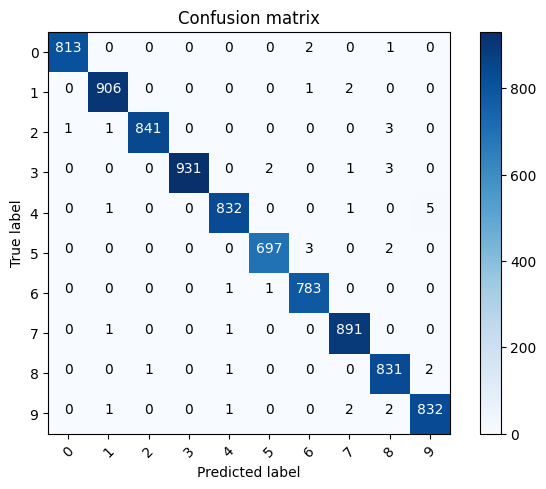

In [173]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = y_test_df['Pred']
y_true = y_test_df['True']
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

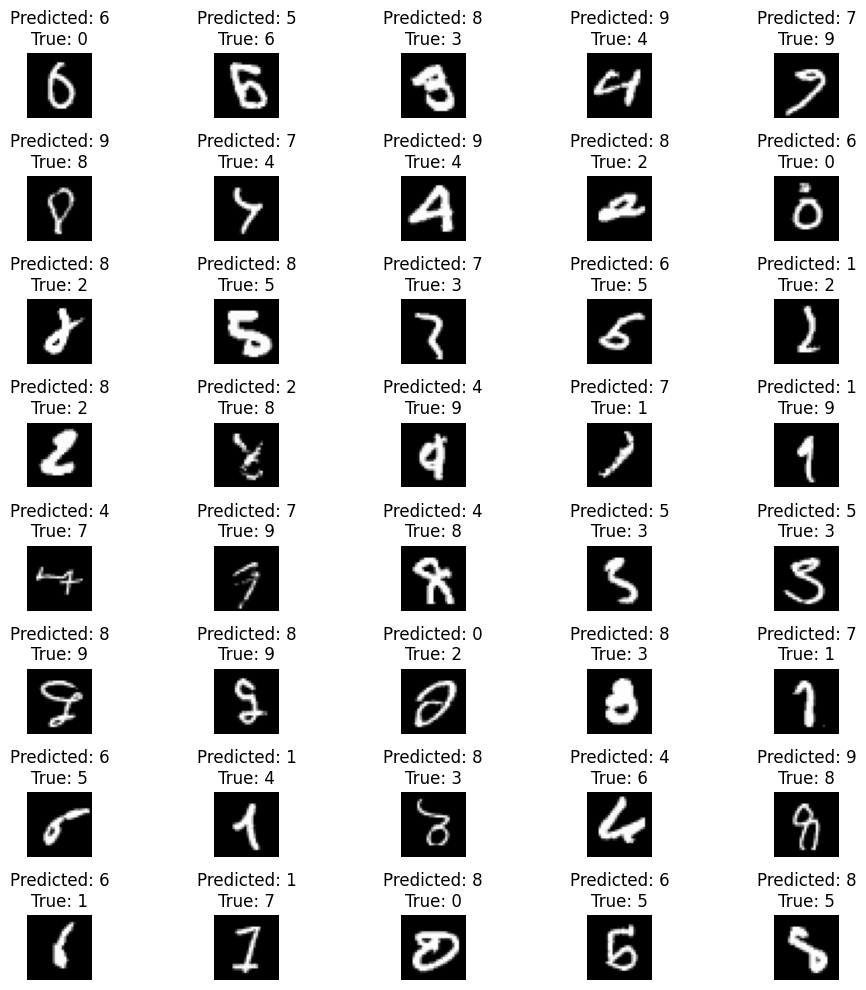

In [174]:
errors = (y_test_df['Pred'] != y_test_df['True'])

# Filter for erroneous predictions
y_pred_err = y_test_df['Pred'][errors]
y_true_err = y_test_df['True'][errors]
Y_pred_errors = y_test_df.drop(columns=['True', 'Pred'])[errors].to_numpy()  # Probabilities part
X_val_errors = X_test.reset_index(drop=True)[errors]  # Ensure X_test's dimensions align, it should include necessary reshaping pre-statement

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 8
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow(img_errors.iloc[error].values.reshape((28, 28)), cmap='gray')
            ax[row, col].set_title("Predicted: {}\nTrue: {}".format(pred_errors.iloc[error], obs_errors.iloc[error]))
            ax[row, col].axis('off')
            n += 1
    plt.tight_layout()
    plt.show()

# Probabilities of the wrongly predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.array([output[true_cls] for output, true_cls in zip(Y_pred_errors, y_true_err)])

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta probability errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors
display_errors(most_important_errors, X_val_errors, y_pred_err, y_true_err)

In [98]:
from torch.utils.data import DataLoader, Dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming the DataFrame has n rows of images with c columns, flattened
        image = self.dataframe.iloc[idx].values.astype(np.float32)
        image = torch.tensor(image).view(1, int(len(image)**0.5), -1)  # assuming square images
        return image

# Step 2: Create a function to output probabilities
def output_probabilities(cnn_model, dataframe, batch_size=32):
    # Ensure the model is in evaluation mode
    cnn_model.eval()

    # Get the device from the model
    device = next(cnn_model.parameters()).device

    # Create a DataLoader
    dataset = ImageDataset(dataframe)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_probabilities = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        for images in dataloader:
            # Move images to the same device as the model
            images = images.to(device)

            # Get raw model outputs
            outputs = cnn_model(images)

            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Append to results
            all_probabilities.append(probabilities.cpu())

    # Concatenate all probabilities and return
    all_probabilities = torch.cat(all_probabilities, dim=0)
    return all_probabilities
    
probabilities = output_probabilities(model, X_val_errors)
probabilities[most_important_errors[20], :]

tensor([0.0853, 0.0853, 0.0853, 0.0853, 0.0854, 0.0853, 0.2318, 0.0853, 0.0853,
        0.0853])

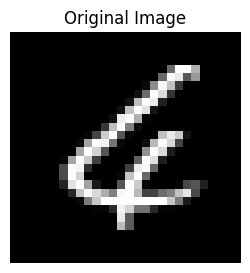

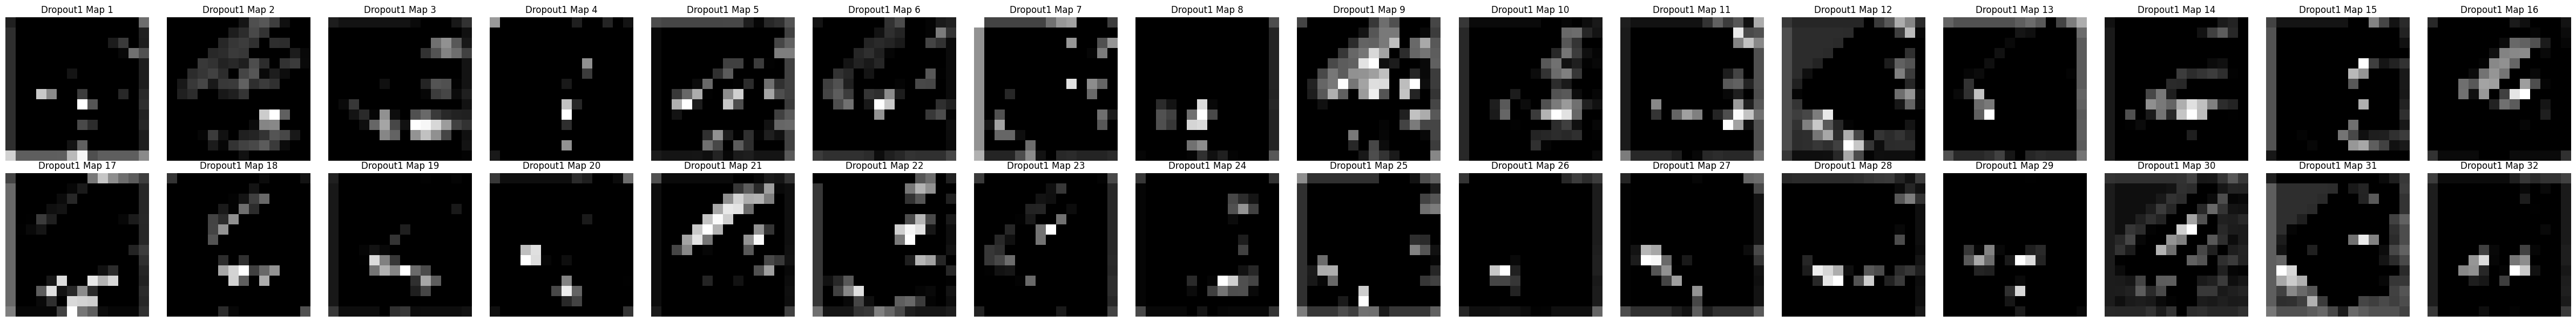

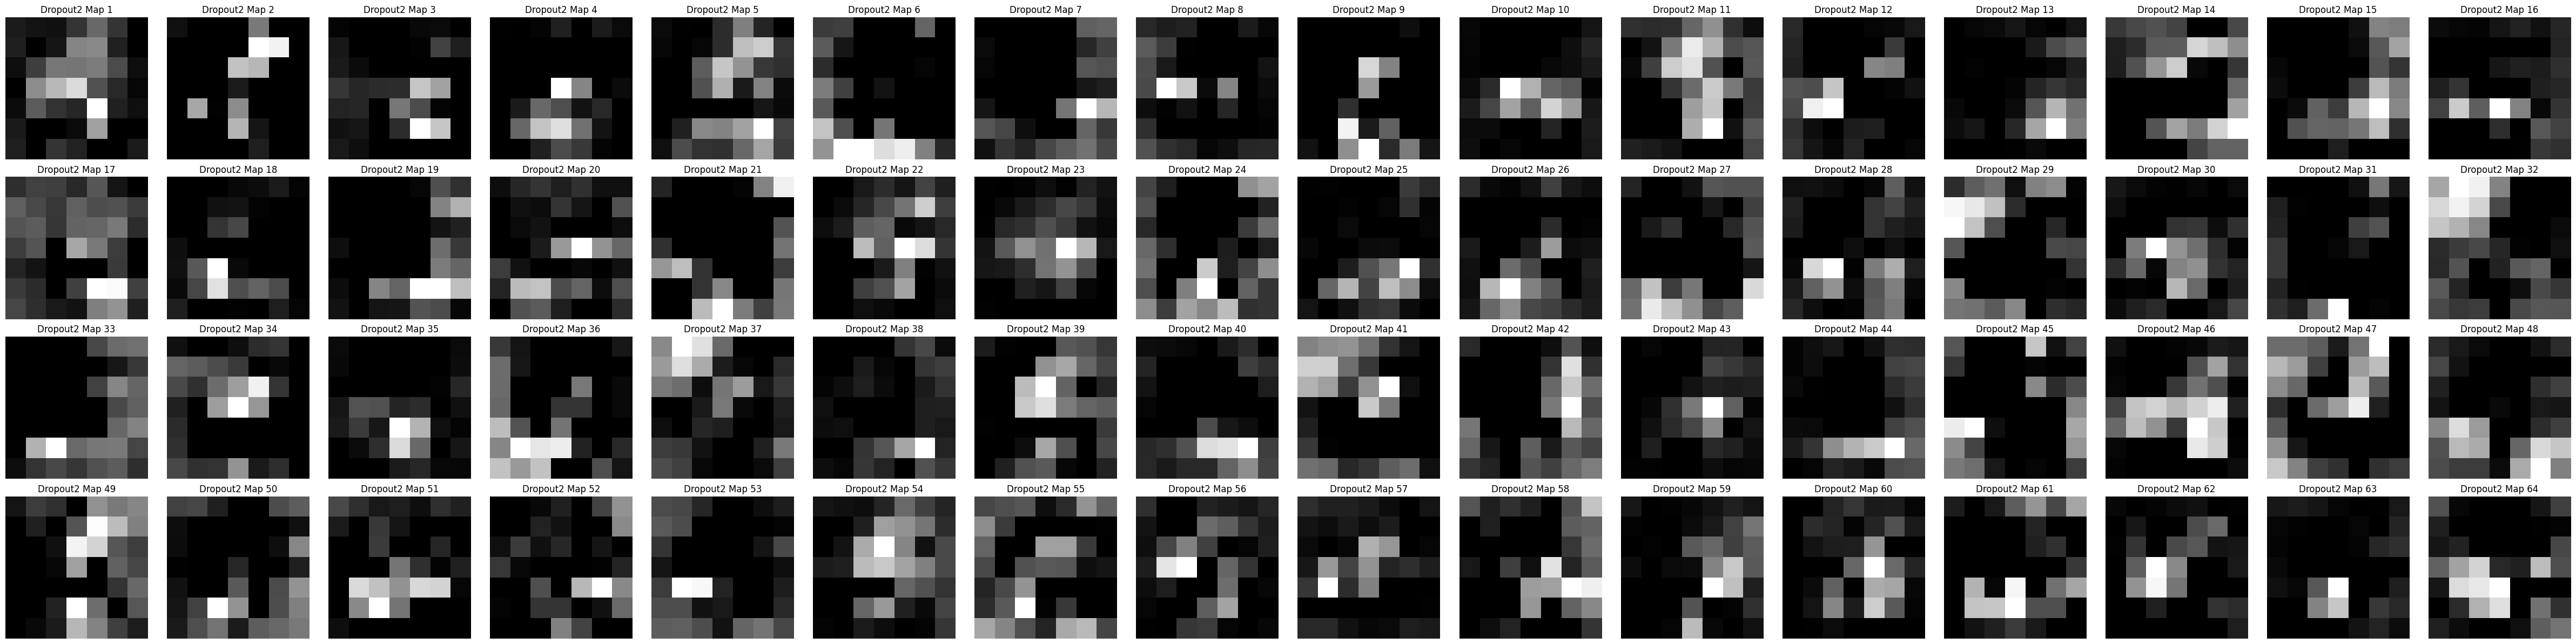

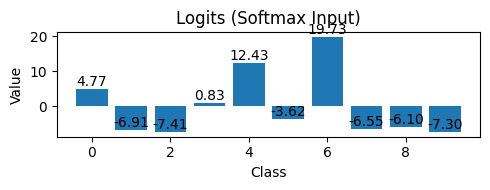

In [111]:
def model_snapshots(model, x):
    x = F.relu(model.bn1(model.conv1(x)))
    x = F.relu(model.bn2(model.conv2(x)))
    x = model.pool1(x)
    x_after_dropout1 = model.dropout1(x)

    x = F.relu(model.bn3(model.conv3(x_after_dropout1)))
    x = F.relu(model.bn4(model.conv4(x)))
    x = model.pool2(x)
    x_after_dropout2 = model.dropout2(x)

    x = model.flatten(x_after_dropout2)
    x = F.relu(model.fc1(x))
    x_after_dropout3 = model.dropout3(x)
    x_out = model.fc2(x_after_dropout3)
    return x_after_dropout1, x_after_dropout2, x_out

def plot_images(original, drop1, drop2, logits):
    num_features_drop1 = drop1.shape[1]
    num_features_drop2 = drop2.shape[1]

    # Determine grid dimensions for plots
    cols = 16
    rows_first = (num_features_drop1 // cols) + int(num_features_drop1 % cols != 0)
    rows_second = (num_features_drop2 // cols) + int(num_features_drop2 % cols != 0)

    # Plot original image
    plt.figure(figsize=(3, 3))
    plt.imshow(original.squeeze(0).squeeze(0), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Plot each feature map from drop1 in a kx4 grid
    fig1, axarr1 = plt.subplots(rows_first, cols, figsize=(cols * 3, rows_first * 3))
    for i in range(num_features_drop1):
        ax = axarr1[i // cols, i % cols]
        drop1_image = drop1.detach().numpy()[0, i, :, :]
        ax.imshow(drop1_image, cmap='gray')
        ax.set_title(f"Dropout1 Map {i+1}")
        ax.axis('off')
    for ax in axarr1.flatten()[num_features_drop1:]: # hide unused subplots
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot each feature map from drop2 in a kx4 grid
    fig2, axarr2 = plt.subplots(rows_second, cols, figsize=(cols * 3, rows_second * 3))
    for i in range(num_features_drop2):
        ax = axarr2[i // cols, i % cols]
        drop2_image = drop2.detach().numpy()[0, i, :, :]
        ax.imshow(drop2_image, cmap='gray')
        ax.set_title(f"Dropout2 Map {i+1}")
        ax.axis('off')
    for ax in axarr2.flatten()[num_features_drop2:]: # hide unused subplots
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Plot softmax input as a bar graph with annotations
    fig3, ax3 = plt.subplots(figsize=(5, 2))
    logit_values = logits.detach().numpy().squeeze()
    ax3.bar(range(len(logit_values)), logit_values)
    ax3.set_title("Logits (Softmax Input)")
    ax3.set_xlabel("Class")
    ax3.set_ylabel("Value")
    for idx, value in enumerate(logit_values):
        ax3.text(idx, value, f'{value:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

image_data = X_val_errors.iloc[most_important_errors[[20]], :].values
image_tensor = torch.from_numpy(image_data).float().view(-1, 1, 28, 28).to(device)  # Move data to device

with torch.no_grad():  # No need to update gradients for visualization
    drop1, drop2, logits = model_snapshots(model, image_tensor)
    
# Plot results
plot_images(image_tensor.cpu(), drop1.cpu(), drop2.cpu(), logits.cpu())

In [37]:
Y_pred_errors[most_important_errors[4]]

array([3.92080508e-40, 1.00000000e+00, 7.83511236e-14, 1.20076248e-15,
       1.58460563e-21, 5.79387533e-38, 3.98325338e-38, 6.44851464e-11,
       1.27648656e-35, 4.71113561e-33])

In [164]:
Xs_tensor = torch.tensor(submit.values.reshape(-1, 1, H, W), dtype=torch.float32)
s_dataset = TensorDataset(Xs_tensor)
s_loader = DataLoader(dataset=s_dataset, batch_size=64)

predictions = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_index, images in enumerate(s_loader):
        images = images[0].to(device)  # Extract the tensor from the tuple
        # images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for idx, prediction in enumerate(predicted):
            image_id = batch_index * s_loader.batch_size + idx
            predictions.append((image_id, int(prediction.item())))

predictions_df = pd.DataFrame(predictions, columns=['ImageID', 'Label'])
predictions_df

,ImageID,Label
0,0,2
1,1,0
2,2,9
3,3,0
4,4,3
...,...,...
27995,27995,9
27996,27996,7
27997,27997,3
27998,27998,9


In [165]:
predictions_df['ImageID'] += 1
predictions_df.to_csv('submit.csv', index=None)